# Synthetic data

<IPython.core.display.Javascript object>


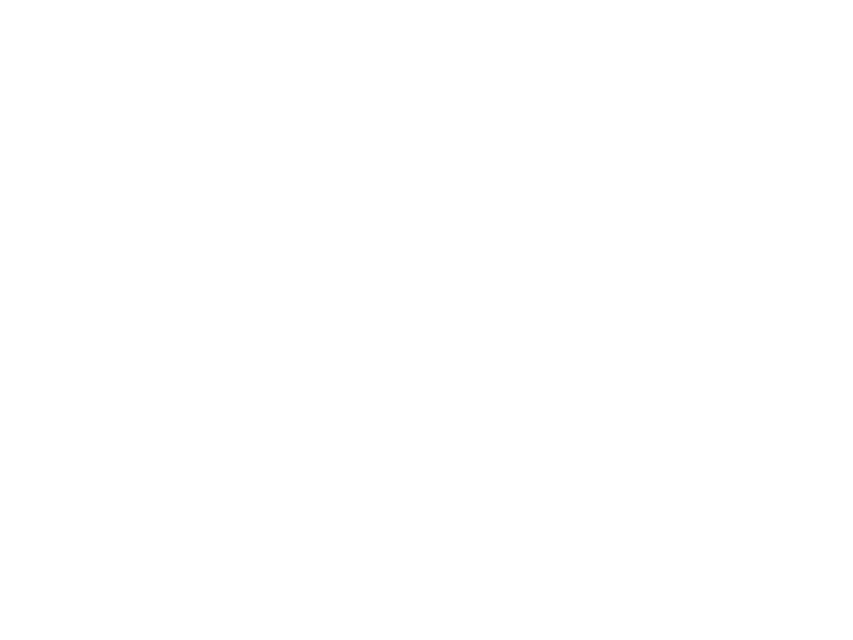

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

N = 500
np.random.seed(0)
X = 3 * np.random.uniform(-1, 1, N)
y = 10. + X - 2 * (X ** 2) + 0.5 * (X ** 3) + np.random.normal(0, 10, N)

fig,ax = plt.subplots()
ax.scatter(X,y, s=10)

# Use OLS to fit this data

In [2]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

poly = PolynomialFeatures(3)
Xols = poly.fit_transform(np.reshape(X,(N,1)))

model = sm.OLS(y, Xols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     117.3
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           1.99e-57
Time:                        18:38:01   Log-Likelihood:                -1852.0
No. Observations:                 500   AIC:                             3712.
Df Residuals:                     496   BIC:                             3729.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3622      0.662     12.626      0.0

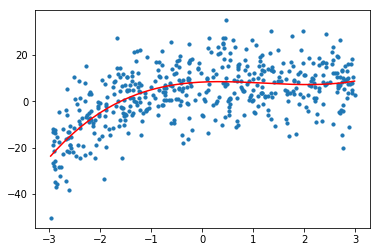

In [3]:
fig,ax = plt.subplots()
ax.scatter(X,y, s=10)
sorted_order = np.argsort(X)
ax.plot(X[sorted_order],results.fittedvalues[sorted_order],'r')

# Ex 3.2(b) : Computing the confidence interval

In [4]:
param_conf = results.conf_int(alpha=0.05, cols=None)
x0 =np.linspace(min(X),max(X),100)

# This is the wrong way to do it.

In [5]:
fx0 = []
for a in param_conf[0,:]:
    for b in param_conf[1,:]:
        for c in param_conf[2,:]:
            for d in param_conf[3,:]:
                fx0.append(a + b*x0 + c*x0**2 + d*x0**3)

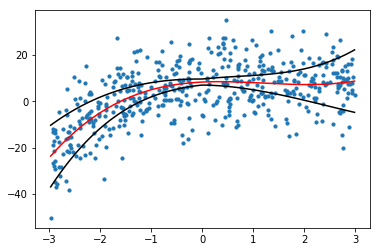

In [6]:
fig,ax = plt.subplots()
ax.scatter(X,y, s=10)
sorted_order = np.argsort(X)
ax.plot(X[sorted_order],results.fittedvalues[sorted_order],'r')

ax.plot(x0,np.max(fx0,0),'k')
ax.plot(x0,np.min(fx0,0),'k')

# Correct way is to sample form the chi-squared distribution

In [7]:
from scipy.stats import chi2
from numpy.linalg import inv

#Compure (XtX)^1
XTX = Xols.T.dot(Xols)
XTX_inv = inv(XTX)

# Compute sigma_hat^2
p = len(results.params)-1 # Exclude the intercept
sigma_hat_2 = np.sum((y - results.fittedvalues)**2)/float(N - p - 1)

$\hat{\beta} \sim N(\beta, (\bf{X}^T\bf{X})\sigma^2)$



$\hat{\beta} - \beta \sim N(0, (\bf{X}^T\bf{X})\sigma^2)$

Sample $\hat{\beta} - \beta$ as a multivariate-Normal and check if the criteria is met. Eq 3.15


In [8]:
from scipy.stats import multivariate_normal
Nsample = 1000

beta = multivariate_normal(mean=np.zeros(p+1),cov=XTX_inv*sigma_hat_2).rvs(Nsample)

In [9]:
selected_beta = np.zeros(Nsample,int)
for n in range(Nsample):
    temp = np.dot(np.matmul(beta[n,:],XTX),beta[n,:])
    if temp <= sigma_hat_2*chi2.ppf(.975,p+1) and temp >= sigma_hat_2*chi2.ppf(.025,p+1):
        selected_beta[n] = 1
    
beta_selected = beta[selected_beta==1,:] + results.params

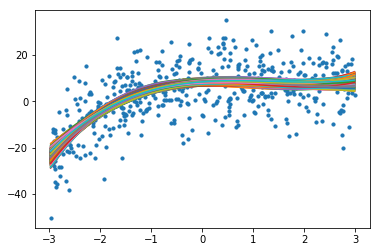

In [10]:
# The points x0 for predicting the confidence bounds
poly = PolynomialFeatures(3)
x0_ols = poly.fit_transform(np.reshape(x0,(len(x0),1)))

fig,ax = plt.subplots()
ax.scatter(X,y, s=10)
for beta_val in beta_selected:
    ax.plot(x0,np.matmul(x0_ols,beta_val))
    

# Ex 3.2(a) : Computing the confidence interval

$\sigma_{0}^{2}=Var(\hat{f}(x_0)|x_0)=Var(x_0^T\hat{\beta}|x_0)=x_0^TVar(\hat{\beta})x_0=\sigma^2x_0^T(X^TX)^{−1}x_0$
 


In [11]:
from numpy.linalg import inv

#Compure (XtX)^1
XTX = Xols.T.dot(Xols)
XTX_inv = inv(XTX)

# Compute sigma_hat^2
p = len(results.params)
sigma_hat_2 = np.sum((y - results.fittedvalues)**2)/float(N - p - 1)

In [12]:
# The points x0 for predicting the confidence bounds
poly = PolynomialFeatures(3)
x0_ols = poly.fit_transform(np.reshape(x0,(len(x0),1)))

In [13]:
from scipy import stats

sigma_fx0 = np.zeros(np.shape(x0_ols)[0])
up_bnd = np.zeros(np.shape(x0_ols)[0])
low_bnd = np.zeros(np.shape(x0_ols)[0])
mean_val = np.zeros(np.shape(x0_ols)[0])
for i in range(np.shape(x0_ols)[0]):
    sigma_fx0[i] = sigma_hat_2*np.dot(np.matmul(x0_ols[i,:],XTX_inv),x0_ols[i,:])
    
    mean_val[i] = np.dot(x0_ols[i,:],results.params)
    up_bnd[i] = mean_val[i] + (stats.t.ppf(1-0.025, len(x0)))*np.sqrt(sigma_fx0[i])
    low_bnd[i] = mean_val[i] - (stats.t.ppf(1-0.025, len(x0)))*np.sqrt(sigma_fx0[i])

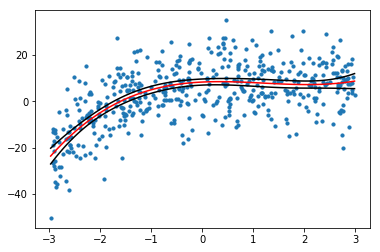

In [14]:
fig,ax = plt.subplots()
ax.scatter(X,y, s=10)

ax.plot(x0,mean_val,'r')
ax.plot(x0,up_bnd,'k')
ax.plot(x0,low_bnd,'k')